## Problem 3 ##
Deliverable: write a likelihood model that provides a reasonable fit for this data
- plot simulations from this model to assess its viability
- fit a gompertz function to this data
- provide the best estimate for parameters a, b, and c

- wrtie an optimization problem to estimate them using max likelihood
- extend this model to a bayesian inference problem
- write as a penalized likelihood prob
- write as a least squares optimization problem

##### References
1. https://github.com/markdregan/Bayesian-Modelling-in-Python
2. https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html 
3. https://m-clark.github.io/models-by-example/penalized-maximum-likelihood.html 
4. https://python.quantecon.org/mle.html

I will assume normal noise in the gompertz pdf for the data.
We start with problem 
### 3a

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


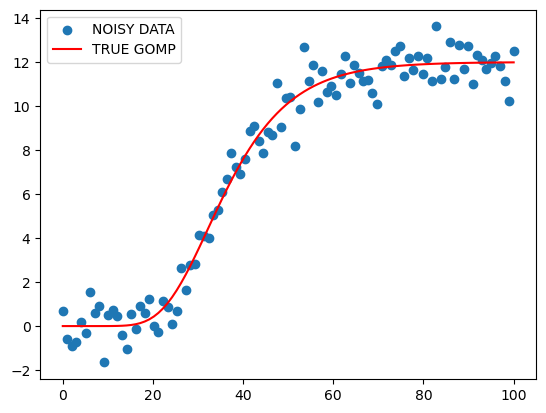

In [1]:
# write a likelihood model for a gompertz function 
import os
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

# GOMP LIKELIHOOD
def gomp(a, b, c, x):
    y_i = a * np.exp(-b * np.exp(-c * x))
    return y_i

def gomp_with_noise(a, b, c, x):
    noise = np.random.normal(0, 0.8, size=len(x))
    y_i = a * np.exp(-b * np.exp(-c * x)) + noise
    return y_i

# arb data
x_values = np.linspace(0, 100, 100)

# GOMP SHAPE
aa, bb, cc = 12, 25, 0.1
yy = gomp_with_noise(aa, bb, cc, x_values)

# NOISY GOMP
y_values = gomp(aa, bb, cc, x_values)

# PLOT NOISY GOMP
plt.scatter(x_values, yy, label="NOISY DATA")
plt.plot(x_values, y_values, color='r', label="TRUE GOMP")
plt.legend()
plt.show()

### 3b - fit a curve to the gompertz likelihood function with maximum likelihood estimation ###

MLE estimates: a=11.742452631317548, b=42.96787575518781, c=0.1168946476449787, sigma=0.9745339355617251


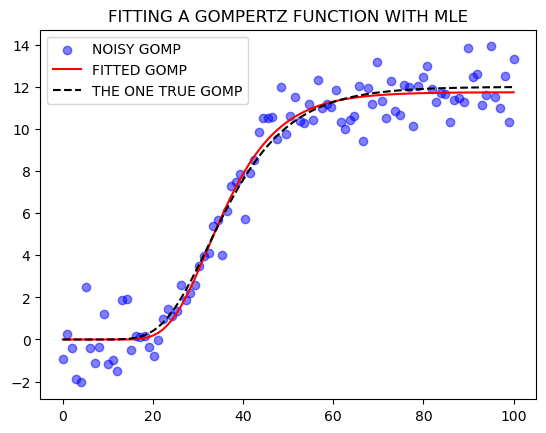

In [2]:
### WRITE LIKELIHOOD WITH MLE ###
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Gompertz function
def gomp(a, b, c, x):
    y_i = a * np.exp(-b * np.exp(-c * x))
    return y_i

# log likelihood for mse
# treat all params as gaussian random variables including sigma
# make MLE easy to solve 
def nll_1(parameters, x, y_obs):
    a, b, c, sigma = parameters
    y_pred = gomp(a, b, c, x)
    # 
    nll = 0.5 * np.sum(((y_obs - y_pred) / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))
    return nll

# arb data
x_values = np.linspace(0, 100, 100)
noise = np.random.normal(0, 0.8, size=len(x_values))

# GOMP SHAPE
aa, bb, cc = 12, 25, 0.1

# define good GOMP (a good gomp bad gomp if you will)
x_values = np.linspace(0, 100, 100)
aa, bb, cc = 12, 25, 0.1  # 
yy = gomp(aa, bb, cc, x_values) #

# noisy GOMP
noise = np.random.normal(0, 1, size=len(x_values))  
y_values = yy + noise

# MLE
mle_start = [10, 15, 0.05, 1]  
result = minimize(nll_1, mle_start, args=(x_values, y_values), method='L-BFGS-B')
a_mle, b_mle, c_mle, sigma_mle = result.x
print(f"MLE estimates: a={a_mle}, b={b_mle}, c={c_mle}, sigma={sigma_mle}")

plt.scatter(x_values, y_values, label="NOISY GOMP", color="blue", alpha=0.5)
plt.plot(x_values, gomp(a_mle, b_mle, c_mle, x_values), color='red', label="FITTED GOMP")
plt.plot(x_values, yy, color='black', linestyle='--', label="THE ONE TRUE GOMP")
plt.legend()
plt.title("FITTING A GOMPERTZ FUNCTION WITH MLE")
plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 21 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.


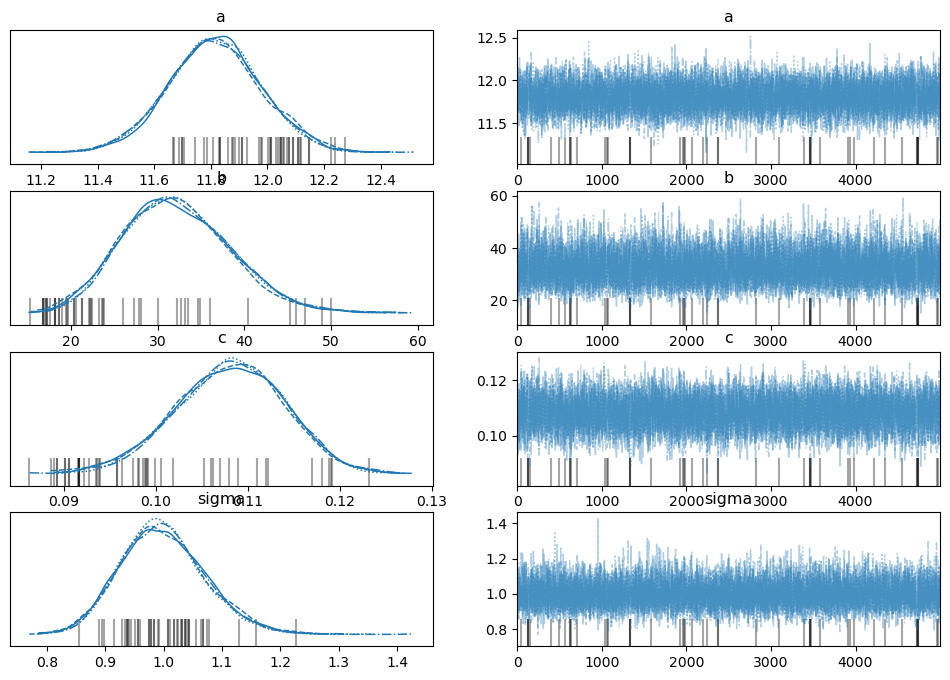

Sampling: [y_likelihood]


Output()

         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
a      11.814  0.162    11.488     12.127      0.002    0.001    8727.0   
b      32.211  6.135    20.189     43.858      0.076    0.054    5840.0   
c       0.108  0.006     0.096      0.119      0.000    0.000    5732.0   
sigma   0.999  0.072     0.858      1.140      0.001    0.000   10664.0   

       ess_tail  r_hat  
a        7468.0    1.0  
b        3386.0    1.0  
c        3508.0    1.0  
sigma    8051.0    1.0  


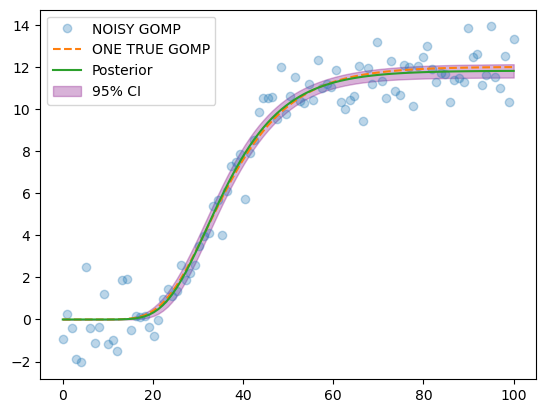

In [3]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

np.random.seed(42)

y_values = yy + noise
initial_guess = [5, 10, 0.05, 1]  
result = minimize(nll_1, initial_guess, args=(x_values, y_values), method='L-BFGS-B')

### bayesian inf problem below ###
with pm.Model() as model:
    # Priors
    a = pm.Normal('a', mu=10, sigma=5) 
    b = pm.Normal('b', mu=20, sigma=10) 
    c = pm.Normal('c', mu=0.1, sigma=0.05) 
    sigma = pm.HalfNormal('sigma', sigma=1) 
    
    # gomp
    y_model = gomp(a, b, c, x_values)
    
    # likelihood
    y_likelihood = pm.Normal('y_likelihood', mu=y_model, sigma=sigma, observed=y_values)
    trace = pm.sample(5000, return_inferencedata=True, random_seed=42)
    
# plot posterior
az.plot_trace(trace)
plt.show()
print(az.summary(trace, hdi_prob=0.95))

with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

posterior_samples_a = trace.posterior['a'].values.flatten()
posterior_samples_b = trace.posterior['b'].values.flatten()
posterior_samples_c = trace.posterior['c'].values.flatten()

y_model_samples = np.array([gomp(a_i, b_i, c_i, x_values) for a_i, b_i, c_i in zip(posterior_samples_a, posterior_samples_b, posterior_samples_c)])

plt.plot(x_values, y_values, 'o', alpha = 0.3, label="NOISY GOMP")
plt.plot(x_values, yy, '--', label="ONE TRUE GOMP")
plt.plot(x_values, np.mean(y_model_samples, axis=0), label="Posterior")
plt.fill_between(x_values, 
                 np.percentile(y_model_samples, 2.5, axis=0),
                 np.percentile(y_model_samples, 97.5, axis=0), 
                 color='purple', alpha=0.3, label="95% CI")
plt.legend()
plt.show()



## 3d. Now write this as a penalized likelihood model
A penalized likelihood model would include a term in the function that would apply constraint to parameter values, such as the L2 norm in Ridge regression. In the case of this Gompertz function, we can put a penalty on the size of the paramers a, b, and c by penalizing their sum. We can even add a penalty for the size of particularly influential parameters such as the c term. 

I will first write this as a maximum likelihood estimation problem and add a penalized term for the parameters of the Gompertz function.

We have the gompertz function for 

$
(y_i, x_i) \in (X, Y) \\
y(x)=a \cdot exp(−b \cdot exp(−c \cdot x))
$

Which we can plug in as our likelihood function such that:

$
\\
L(\theta | \{x_i, y_i\}) = \prod_{i=1}^{n} P(y_i | x_i, \theta) \\
\prod_{i=1}^{n} P(y_i | x_i, \theta) = \prod_{i=1}^{n} y(x)=a \cdot exp(−b \cdot exp(−c \cdot x))\ \text{for}\ {a,b,c}\ \in \ \theta
$

To write this as a penalized likelihood model, we can express the estimation of theta as the minimization of a negative log likelihood model where the likelihood function represents a Gompertz function with normally distributed parameters a, b, and c. We will add a penalization for the sum of the squared parameters as is done in Ridge regression, where $\lambda$ is the regularization coefficient. We will square the parameters such that the sum is non-negative:

$
\log(L(\theta | \{x_i, y_i\})) = \log(L(\theta)) - \lambda(a^2 + b^2 + c^2)
$

For the Gompertz, we could also write a simpler penalization where only the parameter c is penalized, as we know that this parameter should hold the smallest value of the 3. In that case we could subtract just $\lambda(c^2)$ from the likelihood model when optimizing for c.

## 3e. Now write this as a least squares optimization problem.

I am not sure this would be tractible, but I believe it would work with gradient descent given that the Gompertz function does not have more than one local max/min:

Here we try to find the values of a, b, and c that minimize the value of a basic function. The following describes a least squares optimization problem in which we optimize for each parameter individually such that the objective function can be written as the sum of squared residuals.

$
\Theta = \arg\min_{a, b, c} \sum_{i=1}^{n} ( y_i - a \cdot exp(-b \cdot exp(-c \cdot x_i ))^2 )
$